In [118]:
# Analysis libraries
import numpy as np
import pandas as pd
from scipy.stats import entropy, norm, gamma, linregress, pearsonr
from scipy.optimize import curve_fit
from scipy.special import gamma, hyp2f1
from scipy.stats import ks_2samp, kstest
from scipy.spatial.distance import pdist
from scipy.stats import entropy

from math import inf

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.ticker as tck
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import shapely 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import geopandas as gpd
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LogNorm, SymLogNorm

# Other libraries
import os
import sys
import re
import itertools
from tqdm import tqdm
import pickle

sns.set(font='Avenir', font_scale=1., style='ticks')
figsize_geo = (10,7.5)

colorSRF = '#7BC8F6'
colorDCM = '#000033'

palettename = 'coolwarm'
palette = sns.color_palette(palettename, 32)

golden = (1 + 5 ** 0.5) / 2
cms = 0.393701
figsize = (golden*8*cms,8*cms)

sns.set(rc={'figure.figsize':(3.5,3.5), 'figure.dpi':150, 'savefig.dpi':300})
sns.set_theme(font="Avenir", font_scale=1., style="ticks")


# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
sys.path.append('../scripts')
from utils import *
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import numpy as np
from scipy.special import zeta

class Zipf:
    def __init__(self, alpha):
        self.alpha = alpha

# Helper function for generalized harmonic numbers
def harmonic(n, alpha):
    return sum(1 / (k ** alpha) for k in range(1, n + 1))

# Calculate the normalization constant (Riemann zeta function)
def normalization_constant(zipf):
    return zeta(zipf.alpha + 1)

# PDF of the Zipf distribution
def pdf(zipf, x):
    if x < 1:
        return 0.0
    zeta_val = normalization_constant(zipf)
    return x ** (-zipf.alpha - 1) / zeta_val

# CDF of the Zipf distribution
def cdf(zipf, x):
    if x < 1:
        return 0.0
    zeta_val = normalization_constant(zipf)
    H_x = harmonic(x, zipf.alpha + 1)
    return H_x / zeta_val

# Random sampling from the Zipf distribution
def zipfrand(zipf, max_val=10000):
    if zipf.alpha >= 1:
        u = np.random.rand()
        x = 1
        while cdf(zipf, x) < u:
            x += 1
        return x
    else:
        u = np.random.rand()
        left, right = 1, 2
        
        # Expand interval until one endpoint is below and the other is above `u`
        while cdf(zipf, right) < u:
            left = right
            right *= 2
            if right > max_val:
                right = max_val + 1
                break

        # Perform binary search within the identified interval
        while left < right:
            mid = int(np.sqrt(left * right))  # Logarithmic step: Geometric mean
            if cdf(zipf, mid) < u:
                left = mid + 1
            else:
                right = mid
        return left

In [5]:
data_dir = '../../data/processed/'
fig_dir = '../../fig/'

In [10]:
# import metadata

filename_meta = os.path.join(data_dir, 'Tara/woa_pisces_tarassd.tsv')
metadata_tara = pd.read_csv(filename_meta, sep ='\t')
gdf_metadata_tara = gpd.GeoDataFrame(metadata_tara, geometry=gpd.points_from_xy(metadata_tara.longitude, metadata_tara.latitude), crs="ESRI:54030")
# rename SUR to SRF in depth_category column
gdf_metadata_tara['depth_category'] = gdf_metadata_tara['depth_category'].replace('SUR', 'SRF')

# station 50 is missing!
# station 19 will be further removed because of bad data
gdf_metadata_tara.tail()

,station,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,po4_woa,sioh4_woa,dco,dcu,dfe,dzn,geometry
129,205,72.4693,-71.8920,SRF,5,10,584.5,0.863434,31.219290,1.793274,0.440587,3.355274,107.994,0.848,1.990,1.035,POINT (-71.892 72.469)
130,206,70.9618,-53.6030,SRF,5,10,564.5,3.778420,32.896900,1.785118,0.084252,2.914919,-999.000,-999.000,-999.000,-999.000,POINT (-53.603 70.962)
131,208,69.1136,-51.5086,SRF,5,10,508.0,5.208495,33.131413,1.630793,0.000000,3.127574,-999.000,-999.000,-999.000,-999.000,POINT (-51.509 69.114)
132,209,64.7127,-53.0106,SRF,5,10,531.5,2.181750,32.442013,3.216127,0.491307,0.668157,90.334,0.996,2.416,1.333,POINT (-53.011 64.713)
133,210,61.5442,-55.9865,SRF,5,10,535.0,4.107008,33.989799,3.419286,0.553510,2.276372,61.584,1.006,0.427,1.519,POINT (-55.986 61.544)


In [12]:
# import abundances

filename_abund = os.path.join(data_dir, 'Tara/Tara_diatoms.csv')
Abundances = pd.read_csv(filename_abund, index_col=0, header=0)
# since the column 019_SRF has a total abundance of 3, we remove it both from Abundances and gdf
Abundances = Abundances.drop(columns=['019_SRF'])
gdf_metadata_tara = gdf_metadata_tara.loc[~gdf_metadata_tara['station'].isin([19])]
Normalized_Abundances = Abundances/Abundances.sum(axis=0)

Depths = {d: [c for c in Abundances.columns if c[-3:]==d] for d in ['SRF','DCM']}
Stations = np.unique([int(c.split('_')[0]) for c in Abundances[Abundances.sum(axis=1)>0].columns])
print (' Number of stations: {} \n Number of different OTUs: {}'.format(len(Stations), len(Abundances)))
print ('\n Number of stations SRF: {} \n Number of stations DCM: {}'.format(len(Depths['SRF']),len(Depths['DCM'])))

SRF_Abundances = Abundances[Depths['SRF']]
DCM_Abundances = Abundances[Depths['DCM']]

 Number of stations: 124 
 Number of different OTUs: 5830

 Number of stations SRF: 124 
 Number of stations DCM: 58


# 1. Preliminary exploration

In [13]:
SRF_Abundances

,158_SRF,188_SRF,194_SRF,206_SRF,191_SRF,196_SRF,173_SRF,178_SRF,189_SRF,209_SRF,...,147_SRF,148_SRF,149_SRF,045_SRF,150_SRF,151_SRF,152_SRF,047_SRF,049_SRF,078_SRF
0007584343baed6a66bc624ab07afa51,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000d7f48a59463756281b4ea64af743f,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001dedda63f65dd120ccef5ed9eff10a,0,0,2,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002590d1d8d94af8dfcf5980c719d116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00374edaf2b110b52ffe3daea3626d01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffbb560ce62f5a7dd92040a2be6fbcb4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffbec099d69da313c5253f88e48d23c9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffe268d3373da1dd4a156f814ccc09e8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ffe8a780861ace578bc742dae5b7efa3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
number_of_bloomers = 2
abundance_thsh = 1

biomass_bloom = {}
biomass_bulk = {}
richness_bloom = {}
richness_bulk = {}
rho_bulk = {}
pvalue_bulk = {}
rho_linear_fit = {}

for column in Abundances.columns:
    station = int(column.split('_')[0])
    depth = column[-3:]
   
    data = Abundances[column]
    data = data[data>abundance_thsh]
    data = data.sort_values(ascending=False)
    rank = np.arange(1,len(data)+1)
    
    bloom_data = data[:number_of_bloomers]
    bulk_data = data[number_of_bloomers:]
    
    biomass_bloom[column] = bloom_data.sum()
    biomass_bulk[column] = bulk_data.sum()
    
    richness_bloom[column] = len(bloom_data)
    richness_bulk[column] = len(bulk_data)

In [30]:
SRF_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='SRF']
DCM_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='DCM']

# add the relative biomass to the gdf
SRF_gdf['biomass_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='SRF'})
SRF_gdf['biomass_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='SRF'})
SRF_gdf['biomass_total'] = SRF_gdf['biomass_bloom'] + SRF_gdf['biomass_bulk']
SRF_gdf['relative_biomass_bloom'] = SRF_gdf['biomass_bloom']/SRF_gdf['biomass_total']
SRF_gdf['relative_biomass_bulk'] = SRF_gdf['biomass_bulk']/SRF_gdf['biomass_total']
SRF_gdf['richness_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='SRF'})
SRF_gdf['richness_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='SRF'})
SRF_gdf['richness_total'] = SRF_gdf['richness_bloom'] + SRF_gdf['richness_bulk']

DCM_gdf['biomass_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='DCM'})
DCM_gdf['biomass_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='DCM'})
DCM_gdf['biomass_total'] = DCM_gdf['biomass_bloom'] + DCM_gdf['biomass_bulk']
DCM_gdf['relative_biomass_bloom'] = DCM_gdf['biomass_bloom']/DCM_gdf['biomass_total']
DCM_gdf['relative_biomass_bulk'] = DCM_gdf['biomass_bulk']/DCM_gdf['biomass_total']
DCM_gdf['richness_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='DCM'})
DCM_gdf['richness_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='DCM'})
DCM_gdf['richness_total'] = DCM_gdf['richness_bloom'] + DCM_gdf['richness_bulk']

SRF_gdf['K_total'] = SRF_gdf['richness_total']/SRF_gdf['biomass_total']**0.5
SRF_gdf['K_bulk'] = SRF_gdf['richness_bulk']/SRF_gdf['biomass_bulk']**0.5

DCM_gdf['K_total'] = DCM_gdf['richness_total']/DCM_gdf['biomass_total']**0.5
DCM_gdf['K_bulk'] = DCM_gdf['richness_bulk']/DCM_gdf['biomass_bulk']**0.5


bloom_thsh = 1e-2
richness_thsh = 1

SRF_gdf['bloom'] = ((SRF_gdf['relative_biomass_bulk']<bloom_thsh) & (SRF_gdf['richness_total']>richness_thsh))
DCM_gdf['bloom'] = ((DCM_gdf['relative_biomass_bulk']<bloom_thsh) & (DCM_gdf['richness_total']>richness_thsh))

# classes 
# if the relative biomass of the bloom is less than 10% and the richness is >50, it is a hyperdominated
# if the relative biomass of the bloom is less than 10% and the richness is <50, it is a poor
# if the relative biomass of the bloom is more than 10% it is non-bloom
bloom_thsh = 2e-2
richness_thsh = 50
SRF_gdf['classes'] = SRF_gdf.apply(lambda x: 'species-rich,\nhyperdominated' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']>richness_thsh else 'species-poor' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']<richness_thsh else 'intermediate', axis=1)
SRF_gdf['classes'] = SRF_gdf['classes'].astype('category')

SRF_gdf.tail()

,station,latitude,longitude,depth_category,depth_nominal,month,SSD,temp_woa,sal_woa,no3_woa,...,biomass_total,relative_biomass_bloom,relative_biomass_bulk,richness_bloom,richness_bulk,richness_total,K_total,K_bulk,bloom,classes
129,205,72.4693,-71.8920,SRF,5,10,584.5,0.863434,31.219290,1.793274,...,1558148.0,0.630722,0.369278,2.0,348.0,350.0,0.280391,0.458773,False,intermediate
130,206,70.9618,-53.6030,SRF,5,10,564.5,3.778420,32.896900,1.785118,...,364698.0,0.848379,0.151621,2.0,233.0,235.0,0.389136,0.990853,False,intermediate
131,208,69.1136,-51.5086,SRF,5,10,508.0,5.208495,33.131413,1.630793,...,27770.0,0.646669,0.353331,2.0,102.0,104.0,0.624087,1.029725,False,intermediate
132,209,64.7127,-53.0106,SRF,5,10,531.5,2.181750,32.442013,3.216127,...,240992.0,0.410499,0.589501,2.0,273.0,275.0,0.560185,0.724301,False,intermediate
133,210,61.5442,-55.9865,SRF,5,10,535.0,4.107008,33.989799,3.419286,...,70894.0,0.609967,0.390033,2.0,117.0,119.0,0.446933,0.703607,False,intermediate


In [31]:
zipf_dist = Zipf(alpha=0.5)
# total 
S_bulk_empirical = SRF_gdf['richness_bulk'].values
S_bulk_empirical = S_bulk_empirical[S_bulk_empirical>0]
N_bulk_synthetic = np.array([
    np.mean([np.sum([zipfrand(Zipf(alpha=0.5), max_val=1*S) for S in range(int(S_bulk_empirical[i]))]) for _ in range(10)])
    for i in range(len(S_bulk_empirical))
])
K_bulk_synthetic = S_bulk_empirical/N_bulk_synthetic**0.5
logK_bulk_synthetic = [np.abs(np.log10(K_bulk_synthetic[i])-np.log10(K_bulk_synthetic[j])) for i in range(len(K_bulk_synthetic)) for j in range(i+1, len(K_bulk_synthetic))]

In [32]:
logK_bulk_synthetic

[np.float64(0.10197414019072276),
 np.float64(0.15462883563629326),
 np.float64(0.004506332595568485),
 np.float64(0.0805701505161232),
 np.float64(0.001418321660561439),
 np.float64(0.22069982259458037),
 np.float64(0.00324499219215979),
 np.float64(0.0351872282835215),
 np.float64(0.1326157824847533),
 np.float64(0.09603806459984143),
 np.float64(0.08783713915585512),
 np.float64(0.07425699999458657),
 np.float64(0.07368862665974885),
 np.float64(0.07206203656457144),
 np.float64(0.009986497178874454),
 np.float64(0.00015721575614335848),
 np.float64(0.0011765653563142742),
 np.float64(0.010319898056902366),
 np.float64(0.06900125906355159),
 np.float64(0.11220893649641961),
 np.float64(0.07601784728698419),
 np.float64(0.16124438814412245),
 np.float64(0.04665313269762145),
 np.float64(0.008639460426403456),
 np.float64(0.09015631146333725),
 np.float64(0.21116288212092177),
 np.float64(0.12270467056253298),
 np.float64(0.0208150445741353),
 np.float64(0.1374072408017204),
 np.float

In [33]:
# build a distance dataframe using the K index
# use the K index for the bulk
d_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
d_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

d_log_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
d_log_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

for i, row in SRF_gdf.iterrows():
    for j, row2 in SRF_gdf.iterrows():
        d_total.loc[row['station'], row2['station']] = (row['K_total']-row2['K_total'])**2
        d_bulk.loc[row['station'], row2['station']] = (row['K_bulk']-row2['K_bulk'])**2
        d_log_total.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_total'])-np.log10(row2['K_total'])))
        d_log_bulk.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_bulk'])-np.log10(row2['K_bulk'])))

# remove nan columns and nan rows
d_total = d_total.dropna(axis=0, how='all')
d_total = d_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_bulk = d_bulk.dropna(axis=0, how='all')
d_bulk = d_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_log_total = d_log_total.dropna(axis=0, how='all')
d_log_total = d_log_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
d_log_bulk = d_log_bulk.dropna(axis=0, how='all')
d_log_bulk = d_log_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')

# sort index and column by bloom status and  by number
sorted_index = SRF_gdf.sort_values(by=['station','bloom'], ascending=False)['station']
# last station with bloom = True
blooms_stations = len(SRF_gdf[SRF_gdf['bloom']==True])
# remove index that are not present in the distance matrix
sorted_index = sorted_index[sorted_index.isin(d_bulk.index)]
print(sorted_index)
d_total = d_total.loc[sorted_index, sorted_index]
d_bulk = d_bulk.loc[sorted_index, sorted_index]
d_log_total = d_log_total.loc[sorted_index, sorted_index]
d_log_bulk = d_log_bulk.loc[sorted_index, sorted_index]

133    210
132    209
131    208
130    206
129    205
      ... 
4       12
3       11
2       10
1        8
0        7
Name: station, Length: 123, dtype: int64


In [34]:
d_log_bulk_values = d_log_bulk.mask(np.triu(np.ones_like(d_log_bulk, dtype=bool))).values
d_log_bulk_values = d_log_bulk_values[~np.isnan(d_log_bulk_values)]
d_log_bulk_values

array([0.01258866, 0.16539096, 0.1528023 , ..., 0.49127265, 0.15516043,
       0.17263574], shape=(7503,))

In [35]:
logK_bulk_synthetic

[np.float64(0.10197414019072276),
 np.float64(0.15462883563629326),
 np.float64(0.004506332595568485),
 np.float64(0.0805701505161232),
 np.float64(0.001418321660561439),
 np.float64(0.22069982259458037),
 np.float64(0.00324499219215979),
 np.float64(0.0351872282835215),
 np.float64(0.1326157824847533),
 np.float64(0.09603806459984143),
 np.float64(0.08783713915585512),
 np.float64(0.07425699999458657),
 np.float64(0.07368862665974885),
 np.float64(0.07206203656457144),
 np.float64(0.009986497178874454),
 np.float64(0.00015721575614335848),
 np.float64(0.0011765653563142742),
 np.float64(0.010319898056902366),
 np.float64(0.06900125906355159),
 np.float64(0.11220893649641961),
 np.float64(0.07601784728698419),
 np.float64(0.16124438814412245),
 np.float64(0.04665313269762145),
 np.float64(0.008639460426403456),
 np.float64(0.09015631146333725),
 np.float64(0.21116288212092177),
 np.float64(0.12270467056253298),
 np.float64(0.0208150445741353),
 np.float64(0.1374072408017204),
 np.float

In [36]:
from scipy.stats import entropy

# Convert both distributions to numpy arrays
empirical = np.array(d_log_bulk.values[np.triu_indices_from(d_log_bulk.values, k=1)])
empirical = empirical[~np.isnan(empirical)]
synthetic = np.array(logK_bulk_synthetic)

# Histogram binning (shared bins for both distributions)
bins = np.histogram_bin_edges(np.concatenate([empirical, synthetic]), bins='auto')
emp_hist, _ = np.histogram(empirical, bins=bins, density=True)
syn_hist, _ = np.histogram(synthetic, bins=bins, density=True)

# Add small value to avoid log(0)
emp_hist += 1e-12
syn_hist += 1e-12

kl_div = entropy(emp_hist, syn_hist)
print("KL divergence (empirical || synthetic):", kl_div)

KL divergence (empirical || synthetic): 0.9442726224316361


# 2. Iteratively remove a species in all stations

## A. Non-optimized code

In [40]:
numbers_of_bloomers = np.arange(1,21)   
kl_divergences = []
number_of_synthetic_samples = 100

for number_of_bloomers in numbers_of_bloomers:
    abundance_thsh = 1

    biomass_bloom = {}
    biomass_bulk = {}
    richness_bloom = {}
    richness_bulk = {}
    rho_bulk = {}
    pvalue_bulk = {}
    rho_linear_fit = {}

    for column in Abundances.columns:
        station = int(column.split('_')[0])
        depth = column[-3:]
    
        data = Abundances[column]
        data = data[data>abundance_thsh]
        data = data.sort_values(ascending=False)
        rank = np.arange(1,len(data)+1)
        
        bloom_data = data[:number_of_bloomers]
        bulk_data = data[number_of_bloomers:]
        
        biomass_bloom[column] = bloom_data.sum()
        biomass_bulk[column] = bulk_data.sum()
        
        richness_bloom[column] = len(bloom_data)
        richness_bulk[column] = len(bulk_data)

    SRF_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='SRF']
    DCM_gdf = gdf_metadata_tara[gdf_metadata_tara['depth_category']=='DCM']

    # add the relative biomass to the gdf
    SRF_gdf['biomass_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='SRF'})
    SRF_gdf['biomass_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='SRF'})
    SRF_gdf['biomass_total'] = SRF_gdf['biomass_bloom'] + SRF_gdf['biomass_bulk']
    SRF_gdf['relative_biomass_bloom'] = SRF_gdf['biomass_bloom']/SRF_gdf['biomass_total']
    SRF_gdf['relative_biomass_bulk'] = SRF_gdf['biomass_bulk']/SRF_gdf['biomass_total']
    SRF_gdf['richness_bloom'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='SRF'})
    SRF_gdf['richness_bulk'] = SRF_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='SRF'})
    SRF_gdf['richness_total'] = SRF_gdf['richness_bloom'] + SRF_gdf['richness_bulk']

    DCM_gdf['biomass_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bloom.items() if key[-3:]=='DCM'})
    DCM_gdf['biomass_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in biomass_bulk.items() if key[-3:]=='DCM'})
    DCM_gdf['biomass_total'] = DCM_gdf['biomass_bloom'] + DCM_gdf['biomass_bulk']
    DCM_gdf['relative_biomass_bloom'] = DCM_gdf['biomass_bloom']/DCM_gdf['biomass_total']
    DCM_gdf['relative_biomass_bulk'] = DCM_gdf['biomass_bulk']/DCM_gdf['biomass_total']
    DCM_gdf['richness_bloom'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bloom.items() if key[-3:]=='DCM'})
    DCM_gdf['richness_bulk'] = DCM_gdf['station'].map({int(key.split('_')[0]): value for key,value in richness_bulk.items() if key[-3:]=='DCM'})
    DCM_gdf['richness_total'] = DCM_gdf['richness_bloom'] + DCM_gdf['richness_bulk']

    SRF_gdf['K_total'] = SRF_gdf['richness_total']/SRF_gdf['biomass_total']**0.5
    SRF_gdf['K_bulk'] = SRF_gdf['richness_bulk']/SRF_gdf['biomass_bulk']**0.5

    DCM_gdf['K_total'] = DCM_gdf['richness_total']/DCM_gdf['biomass_total']**0.5
    DCM_gdf['K_bulk'] = DCM_gdf['richness_bulk']/DCM_gdf['biomass_bulk']**0.5


    bloom_thsh = 1e-2
    richness_thsh = 1

    SRF_gdf['bloom'] = ((SRF_gdf['relative_biomass_bulk']<bloom_thsh) & (SRF_gdf['richness_total']>richness_thsh))
    DCM_gdf['bloom'] = ((DCM_gdf['relative_biomass_bulk']<bloom_thsh) & (DCM_gdf['richness_total']>richness_thsh))

    # classes 
    # if the relative biomass of the bloom is less than 10% and the richness is >50, it is a hyperdominated
    # if the relative biomass of the bloom is less than 10% and the richness is <50, it is a poor
    # if the relative biomass of the bloom is more than 10% it is non-bloom
    bloom_thsh = 2e-2
    richness_thsh = 50
    SRF_gdf['classes'] = SRF_gdf.apply(lambda x: 'species-rich,\nhyperdominated' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']>richness_thsh else 'species-poor' if x['relative_biomass_bulk']<bloom_thsh and x['richness_total']<richness_thsh else 'intermediate', axis=1)
    SRF_gdf['classes'] = SRF_gdf['classes'].astype('category')

    zipf_dist = Zipf(alpha=0.5)
    # total 
    S_bulk_empirical = SRF_gdf['richness_bulk'].values
    S_bulk_empirical = S_bulk_empirical[S_bulk_empirical>0]
    N_bulk_synthetic = np.array([
        np.mean([np.sum([zipfrand(Zipf(alpha=0.5), max_val=1*S) for S in range(int(S_bulk_empirical[i]))]) for _ in range(number_of_synthetic_samples)])
        for i in range(len(S_bulk_empirical))
    ])
    K_bulk_synthetic = S_bulk_empirical/N_bulk_synthetic**0.5
    logK_bulk_synthetic = [np.abs(np.log10(K_bulk_synthetic[i])-np.log10(K_bulk_synthetic[j])) for i in range(len(K_bulk_synthetic)) for j in range(i+1, len(K_bulk_synthetic))]


    # build a distance dataframe using the K index
    # use the K index for the bulk
    d_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
    d_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

    d_log_total = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])
    d_log_bulk = pd.DataFrame(index=SRF_gdf['station'], columns=SRF_gdf['station'])

    for i, row in SRF_gdf.iterrows():
        for j, row2 in SRF_gdf.iterrows():
            d_total.loc[row['station'], row2['station']] = (row['K_total']-row2['K_total'])**2
            d_bulk.loc[row['station'], row2['station']] = (row['K_bulk']-row2['K_bulk'])**2
            d_log_total.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_total'])-np.log10(row2['K_total'])))
            d_log_bulk.loc[row['station'], row2['station']] = np.abs((np.log10(row['K_bulk'])-np.log10(row2['K_bulk'])))

    # remove nan columns and nan rows
    d_total = d_total.dropna(axis=0, how='all')
    d_total = d_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
    d_bulk = d_bulk.dropna(axis=0, how='all')
    d_bulk = d_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
    d_log_total = d_log_total.dropna(axis=0, how='all')
    d_log_total = d_log_total.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')
    d_log_bulk = d_log_bulk.dropna(axis=0, how='all')
    d_log_bulk = d_log_bulk.dropna(axis=1, how='all').apply(pd.to_numeric, errors='coerce')

    # sort index and column by bloom status and  by number
    sorted_index = SRF_gdf.sort_values(by=['station','bloom'], ascending=False)['station']
    # last station with bloom = True
    blooms_stations = len(SRF_gdf[SRF_gdf['bloom']==True])
    # remove index that are not present in the distance matrix
    sorted_index = sorted_index[sorted_index.isin(d_bulk.index)]
    d_total = d_total.loc[sorted_index, sorted_index]
    d_bulk = d_bulk.loc[sorted_index, sorted_index]
    d_log_total = d_log_total.loc[sorted_index, sorted_index]
    d_log_bulk = d_log_bulk.loc[sorted_index, sorted_index]

    d_log_bulk_values = d_log_bulk.mask(np.triu(np.ones_like(d_log_bulk, dtype=bool))).values
    d_log_bulk_values = d_log_bulk_values[~np.isnan(d_log_bulk_values)]

    # Convert both distributions to numpy arrays
    empirical = np.array(d_log_bulk.values[np.triu_indices_from(d_log_bulk.values, k=1)])
    empirical = empirical[~np.isnan(empirical)]
    synthetic = np.array(logK_bulk_synthetic)

    # Histogram binning (shared bins for both distributions)
    bins = np.histogram_bin_edges(np.concatenate([empirical, synthetic]), bins='auto')
    emp_hist, _ = np.histogram(empirical, bins=bins, density=True)
    syn_hist, _ = np.histogram(synthetic, bins=bins, density=True)

    # Add small value to avoid log(0)
    emp_hist += 1e-12
    syn_hist += 1e-12

    kl_div = entropy(emp_hist, syn_hist)
    print("KL divergence (empirical || synthetic):", kl_div)
    kl_divergences.append(kl_div)

KL divergence (empirical || synthetic): 1.9511813124400474
KL divergence (empirical || synthetic): 0.8899228491551969
KL divergence (empirical || synthetic): 0.45026516073686484
KL divergence (empirical || synthetic): 0.15871430641696435
KL divergence (empirical || synthetic): 0.07765271777090832
KL divergence (empirical || synthetic): 0.025633688808595647
KL divergence (empirical || synthetic): 0.01664515353320711
KL divergence (empirical || synthetic): 0.017850896444415412
KL divergence (empirical || synthetic): 0.011196478620740382
KL divergence (empirical || synthetic): 0.02388612472919034
KL divergence (empirical || synthetic): 0.01981640775200176
KL divergence (empirical || synthetic): 0.039386086613534765
KL divergence (empirical || synthetic): 0.05874764908521541
KL divergence (empirical || synthetic): 0.054279829264923266
KL divergence (empirical || synthetic): 0.10978887090017268
KL divergence (empirical || synthetic): 0.16134841725074017
KL divergence (empirical || synthetic

## B. Optimized code

In [49]:
# Parametri principali
numbers_of_bloomers = np.arange(0, 21)
number_of_synthetic_samples = 10
abundance_thsh = 1
alpha_zipf = 0.5  # per Zipf(alpha=0.5)

# --- helper: parsing colonne "station_depth" ---
def parse_station_depth(col):
    # es. "42_SRF" -> (42, "SRF")
    station = int(col.split('_')[0])
    depth = col.split('_')[-1]
    return station, depth

# --- helper: somma Zipf troncata con cutoff crescente (replica la tua logica) ---
def simulate_bulk_sum_zipf_trunc(S, nrep, alpha):
    """
    Per ciascuna replica:
      somma_{s=1..S} zipfrand(Zipf(alpha), max_val=s)
    Restituisce media sulle nrep repliche.
    Nota: richiede che esistano funzioni/oggetti zipfrand e Zipf come nel tuo codice.
    """
    if S <= 0:
        return 0.0
    # pre-alloc per efficienza
    acc = 0.0
    for _ in range(nrep):
        total = 0
        for s in range(1, int(S) + 1):
            total += zipfrand(Zipf(alpha=alpha), max_val=s)
        acc += total
    return acc / nrep

# --- 1) Estrai solo SRF e costruisci K_bulk empirico ---
# Filtra colonne SRF
cols_srf = [c for c in Abundances.columns if parse_station_depth(c)[1] == 'SRF']

# Per ogni colonna SRF: filtra, ordina, spezza in bloom/bulk e calcola (richness_bulk, biomass_bulk)
def compute_bulk_stats_for_bloomers(n_bloomers):
    richness_bulk = {}
    biomass_bulk = {}
    stations = []

    for col in cols_srf:
        station, _ = parse_station_depth(col)
        x = Abundances[col]
        x = x[x > abundance_thsh].sort_values(ascending=False)

        bloom = x.iloc[:n_bloomers]
        bulk  = x.iloc[n_bloomers:]

        richness_bulk[station] = len(bulk)
        biomass_bulk[station]  = bulk.sum()
        stations.append(station)

    stations = pd.Index(stations, name='station')
    rb = pd.Series(richness_bulk).reindex(stations)
    bb = pd.Series(biomass_bulk).reindex(stations)

    # K_bulk empirico (usa solo stazioni con biomass > 0 e richness > 0)
    mask = (rb > 0) & (bb > 0)
    K_emp = (rb[mask] / np.sqrt(bb[mask])).astype(float)

    return K_emp.values  # array dei K_bulk (SRF) validi

# --- 2) Simulazione N_bulk_synthetic e K_bulk_synthetic coerente con la tua logica ---
def simulate_K_bulk_synthetic(S_bulk_array, nrep, alpha):
    """
    Per ogni S in S_bulk_array:
      N_syn = media_repliche [ somma_{s=1..S} Zipf_troncata(max_val=s) ]
      K_syn = S / sqrt(N_syn)
    Ritorna array K_syn (solo per S>0).
    """
    K_list = []
    for S in S_bulk_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc(int(S), nrep, alpha)
        # evita divisione per zero
        if N_syn > 0:
            K_list.append(S / np.sqrt(N_syn))
    return np.array(K_list, dtype=float)

# --- 3) KL divergence tra |log10(K_i) - log10(K_j)| empirico vs sintetico ---
def kl_divergence_for_bloomers(n_bloomers):
    # K empirici (SRF)
    K_emp = compute_bulk_stats_for_bloomers(n_bloomers)
    if len(K_emp) < 2:
        return np.nan  # servono almeno 2 stazioni

    logK_emp = np.log10(K_emp)
    # tutte le differenze pairwise assolute su scala log10
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')  # |x_i - x_j|

    # Per costruire i K sintetici servono gli S_bulk (richness bulk) delle stesse stazioni usate in K_emp
    # Li ricalcoliamo in modo coerente e poi simuliamo
    # (riuso della funzione ma recuperando anche S_bulk)
    S_bulk_list = []
    for col in cols_srf:
        station, _ = parse_station_depth(col)
        x = Abundances[col]
        x = x[x > abundance_thsh].sort_values(ascending=False)
        bulk = x.iloc[n_bloomers:]
        S_bulk_list.append(len(bulk))
    S_bulk_array = np.array([s for s in S_bulk_list if s > 0], dtype=int)
    if len(S_bulk_array) < 2:
        return np.nan

    K_syn = simulate_K_bulk_synthetic(S_bulk_array, number_of_synthetic_samples, alpha_zipf)
    if len(K_syn) < 2:
        return np.nan

    logK_syn = np.log10(K_syn)
    syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')

    # Istogrammi con bin condivisi, densità, smoothing numerico e KL(emp || syn)
    bins = np.histogram_bin_edges(np.concatenate([emp_diffs, syn_diffs]), bins='auto')
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)

    eps = 1e-12
    emp_hist = emp_hist + eps
    syn_hist = syn_hist + eps

    return float(entropy(emp_hist, syn_hist))


In [50]:
# --- 4) ciclo su number_of_bloomers ---
kl_divergences = [kl_divergence_for_bloomers(nb) for nb in numbers_of_bloomers]

In [51]:
kl_divergences

[3.7712668816761123,
 1.3274447659799808,
 0.6411339211599281,
 0.21443230644025912,
 0.09016982147479109,
 0.03166711800680316,
 0.018872968943526407,
 0.02630464065080295,
 0.02251260435511076,
 0.023961495413368433,
 0.023248467974720223,
 0.03111797489073904,
 0.043533711221641735,
 0.04310261029871269,
 0.0689892239118567,
 0.058268346254485695,
 0.10116617019415389,
 0.08534689037239797,
 0.058381978585024426,
 0.06569880539179147,
 0.09496409818037274]

Text(0.5, 1.0, 'KL Divergence vs Number of Bloomers (SRF)')

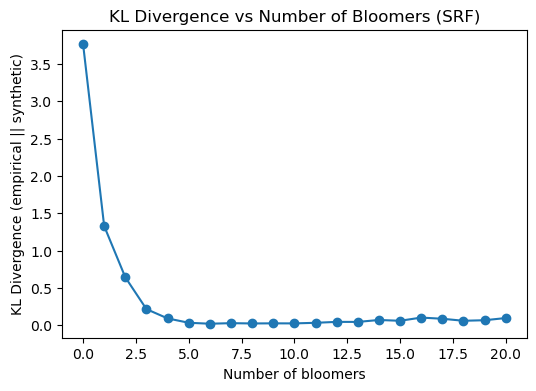

In [52]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(numbers_of_bloomers, kl_divergences, marker='o')
ax.set_xlabel('Number of bloomers')
ax.set_ylabel('KL Divergence (empirical || synthetic)')
ax.set_title('KL Divergence vs Number of Bloomers (SRF)')

## C. Optimized parallel code

In [131]:
from joblib import Parallel, delayed

In [133]:
# ---------------------------
# PARAMETRI
# ---------------------------
abundance_thsh = 1
alpha_zipf = 0.5           # Zipf(alpha=0.5)
number_of_synthetic_samples = 100
N_JOBS = -1                # usa tutti i core
EPS = 1e-12

# ---------------------------
# HELPERS
# ---------------------------
def parse_station_depth(col):
    station = int(col.split('_')[0])
    depth = col.split('_')[-1]
    return station, depth

def simulate_bulk_sum_zipf_trunc_one_rep(S, alpha):
    """Singola replica: somma_{s=1..S} Zipf_troncata(max_val=s) usando zipfrand/Zipf."""
    if S <= 0:
        return 0.0
    total = 0
    for s in range(1, int(S) + 1):
        total += zipfrand(Zipf(alpha=alpha), max_val=s)
    return float(total)

def simulate_K_from_S_one_rep(S_array, alpha):
    """Una replica di K_synth per tutte le stazioni: K = S / sqrt(N_syn)."""
    Ks = []
    for S in S_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc_one_rep(int(S), alpha)
        if N_syn > 0:
            Ks.append(S / np.sqrt(N_syn))
    return np.array(Ks, dtype=float)

# ---------------------------
# COSTRUZIONE EMPIRICO (rimozione top-n_bloomers per stazione)
# ---------------------------
def compute_empirical_after_bloom_removal(Abundances, n_bloomers, abundance_thsh=abundance_thsh):
    """
    Ritorna:
      - emp_diffs: tutte le |Δ log10 K_emp| (pairwise)
      - S_bulk_array: array degli S (richness del bulk) per stazioni valide
    """

    richness_bulk = {}
    biomass_bulk = {}
    stations = []

    for col in cols_srf:
        station, _ = parse_station_depth(col)
        x = Abundances[col]
        x = x[x > abundance_thsh].sort_values(ascending=False)

        bulk = x.iloc[n_bloomers:]  # rimuovi i top n_bloomers
        richness_bulk[station] = len(bulk)
        biomass_bulk[station]  = bulk.sum()
        stations.append(station)

    stations = pd.Index(stations, name='station')
    rb = pd.Series(richness_bulk).reindex(stations)
    bb = pd.Series(biomass_bulk).reindex(stations)

    valid = (rb > 0) & (bb > 0)
    if valid.sum() < 2:
        return np.array([]), np.array([])

    K_emp = (rb[valid] / np.sqrt(bb[valid])).astype(float).values
    logK_emp = np.log10(K_emp)
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')  # |x_i - x_j|
    S_bulk_array = rb[valid].astype(int).values

    return emp_diffs, S_bulk_array

# ---------------------------
# UNA REPLICA: KL(emp || syn) usando bin fissi (da empirico)
# ---------------------------
def kl_one_rep(emp_hist, bins, S_bulk_array, alpha):
    K_syn = simulate_K_from_S_one_rep(S_bulk_array, alpha)
    if len(K_syn) < 2:
        return np.nan
    logK_syn = np.log10(K_syn)
    syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')
    syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)
    syn_hist = syn_hist + EPS
    return float(entropy(emp_hist, syn_hist))

# ---------------------------
# FUNZIONE PRINCIPALE: KL media/std su repliche MC
# ---------------------------
def kl_divergence_for_bloomers_MC(Abundances,
                                  n_bloomers,
                                  nrep=number_of_synthetic_samples,
                                  alpha=alpha_zipf,
                                  n_jobs=N_JOBS,
                                  bins_mode='auto'):
    """
    Calcola KL per ciascuna replica MC (non media su N!), poi ritorna:
      KL_mean, KL_std, KL_values (lista).
    """
    emp_diffs, S_bulk_array = compute_empirical_after_bloom_removal(Abundances, n_bloomers)
    if emp_diffs.size == 0 or len(S_bulk_array) < 2:
        return np.nan, np.nan, []

    # Fissa bin sui soli dati empirici (stabilità)
    bins = np.histogram_bin_edges(emp_diffs, bins=bins_mode)
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    emp_hist = emp_hist + EPS

    # Parallelizza sulle repliche
    KL_vals = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(kl_one_rep)(emp_hist, bins, S_bulk_array, alpha) for _ in range(nrep)
    )
    KL_vals = [v for v in KL_vals if not np.isnan(v)]
    if len(KL_vals) == 0:
        return np.nan, np.nan, []

    KL_vals = np.array(KL_vals, dtype=float)
    return KL_vals.mean(), (KL_vals.std(ddof=1) if len(KL_vals) > 1 else 0.0), KL_vals.tolist()

# ---------------------------
# ESEMPIO: per tutti i n_bloomers
# ---------------------------
# numbers_of_bloomers = np.arange(0, 21)
# results = []
# for nb in numbers_of_bloomers:
#     kl_mean, kl_std, kl_vals = kl_divergence_for_bloomers_MC(Abundances, nb, nrep=100, alpha=0.5, n_jobs=-1)
#     results.append({"n_bloomers": nb, "KL_mean": kl_mean

In [141]:
numbers_of_bloomers = np.arange(0, 31)
results = []
for nb in numbers_of_bloomers:
    kl_mean, kl_std, kl_vals = kl_divergence_for_bloomers_MC(Abundances, nb, nrep=50, alpha=0.5, n_jobs=-1)
    results.append({"n_bloomers": nb, "KL_mean": kl_mean, "KL_std": kl_std, "KL_vals": kl_vals})

In [143]:
results = pd.DataFrame(results)

results.head()

,n_bloomers,KL_mean,KL_std,KL_vals
0,0,2.844205,0.490517,"[3.260220513933444, 2.100187189821416, 2.35993..."
1,1,0.974614,0.242429,"[0.9633048772171521, 0.8911637028739958, 1.185..."
2,2,0.385404,0.148440,"[0.6799092476243038, 0.5069064551362261, 0.512..."
3,3,0.184000,0.071002,"[0.27770593130458165, 0.26642568022442453, 0.0..."
4,4,0.048231,0.024225,"[0.06419380034890694, 0.06482310005242929, 0.0..."


# 3. Greedy search

## parallel version

In [98]:
# ---------------------------
# PARAMETRI (default)
# ---------------------------
ABUNDANCE_TSH = 1
ALPHA_ZIPF    = 0.5
N_SYN_REP     = 10        # numero di repliche MC della KL
EPS           = 1e-12
IMPROVING_FACTOR = 1.0    # accetta qualsiasi miglioramento (>= 1.0)
N_JOBS        = -1        # usa tutti i core

# ---------------------------
# UTILS
# ---------------------------
def parse_station_depth(col):
    station = int(col.split('_')[0])
    depth = col.split('_')[-1]
    return station, depth

def draw_zipf_trunc(max_val, alpha):
    """Un campione Zipf troncato in [1..max_val] usando la tua API zipfrand/Zipf."""
    return zipfrand(Zipf(alpha=alpha), max_val=max_val)

def simulate_bulk_sum_zipf_trunc_one_rep(S, alpha):
    """Singola replica: somma_{s=1..S} Zipf_troncata(max_val=s)."""
    if S <= 0:
        return 0.0
    total = 0
    for s in range(1, int(S) + 1):
        total += draw_zipf_trunc(s, alpha)
    return float(total)

def simulate_K_from_S_one_rep(S_array, alpha):
    """Una replica di K_synth per tutte le stazioni."""
    Ks = []
    for S in S_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc_one_rep(int(S), alpha)
        if N_syn > 0:
            Ks.append(S / np.sqrt(N_syn))
    return np.array(Ks, dtype=float)

# ---------------------------
# METRICA (bulk corrente, nessun SRF filter qui: usi tutto il bulk)
# ---------------------------
def compute_K_and_S_bulk(Abundances, abundance_thsh=ABUNDANCE_TSH):
    """
    Bulk = matrice corrente (dopo eventuali rimozioni).
    Ritorna K_emp (array) e S (richness) per le colonne valide.
    """
    A = Abundances.where(Abundances >= abundance_thsh, other=0)
    richness = (A > 0).sum(axis=0).astype(int)
    biomass  = A.sum(axis=0).astype(float)

    valid = (richness > 0) & (biomass > 0)
    if valid.sum() < 2:
        return np.array([]), np.array([])

    K_emp = (richness[valid] / np.sqrt(biomass[valid])).values.astype(float)
    S_arr = richness[valid].values.astype(int)
    return K_emp, S_arr

def KL_empirical_vs_synthetic_MC(Abundances,
                                 abundance_thsh=ABUNDANCE_TSH,
                                 alpha_zipf=ALPHA_ZIPF,
                                 n_syn_rep=N_SYN_REP,
                                 n_bins='auto'):
    """
    Monte Carlo della KL:
      - fisso emp_diffs (|Δ log10 K_emp|) e i bin UNA VOLTA,
      - per ogni replica r: genero K_syn^(r), faccio syn_diffs^(r), istogrammo sugli stessi bin,
        calcolo KL^(r) = KL(emp || syn^(r)).
    Ritorna: (KL_mean, KL_std, KL_values[])
    """
    K_emp, S_arr = compute_K_and_S_bulk(Abundances, abundance_thsh)
    if len(K_emp) < 2:
        return np.nan, np.nan, []

    logK_emp  = np.log10(K_emp)
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')

    # Bin fissi per tutte le repliche (stabilità della metrica)
    bins = np.histogram_bin_edges(emp_diffs, bins=n_bins)
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    emp_hist = emp_hist + EPS

    KL_vals = []
    for _ in range(n_syn_rep):
        K_syn = simulate_K_from_S_one_rep(S_arr, alpha_zipf)
        if len(K_syn) < 2:
            continue
        logK_syn  = np.log10(K_syn)
        syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')

        syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)
        syn_hist = syn_hist + EPS

        KL_vals.append(float(entropy(emp_hist, syn_hist)))

    if len(KL_vals) == 0:
        return np.nan, np.nan, []

    KL_vals = np.array(KL_vals, dtype=float)
    KL_mean = KL_vals.mean()
    KL_std  = KL_vals.std(ddof=1) if len(KL_vals) > 1 else 0.0
    return KL_mean, KL_std, KL_vals.tolist()

# ---------------------------
# PARALLEL (joblib/loky)
# ---------------------------
def _eval_candidate_joblib(sp, A, abundance_thsh, alpha_zipf, n_syn_rep):
    A_try = A.drop(index=sp)
    kl_mean, kl_std, _ = KL_empirical_vs_synthetic_MC(A_try, abundance_thsh, alpha_zipf, n_syn_rep)
    return sp, kl_mean, kl_std

def parallel_best_removal_joblib(A, candidate_species, kl_curr_mean, improving_factor,
                                 abundance_thsh, alpha_zipf, n_syn_rep,
                                 n_jobs=N_JOBS, verbose=0):
    results = Parallel(n_jobs=n_jobs, backend="loky", verbose=verbose)(
        delayed(_eval_candidate_joblib)(sp, A, abundance_thsh, alpha_zipf, n_syn_rep)
        for sp in candidate_species
    )

    # migliore assoluto (anche se non "improva")
    min_sp, min_mean, min_std = None, inf, None

    # migliore che soddisfa l'improving_factor
    best_sp, best_mean, best_std = None, inf, None

    for sp, m, s in results:
        if np.isnan(m):
            continue
        if m < min_mean:
            min_sp, min_mean, min_std = sp, m, s
        if m < kl_curr_mean * improving_factor and m < best_mean:
            best_sp, best_mean, best_std = sp, m, s

    if min_sp is None:
        return None, (kl_curr_mean, np.nan), False

    if best_sp is None:
        return min_sp, (min_mean, min_std), False

    return best_sp, (best_mean, best_std), True

# ---------------------------
# GREEDY globale: rimuove una specie alla volta
# ---------------------------
def greedy_global_remove_to_minimize_KL(Abundances,
                                        max_remove=50,
                                        candidate_species=None,
                                        abundance_thsh=ABUNDANCE_TSH,
                                        alpha_zipf=ALPHA_ZIPF,
                                        n_syn_rep=N_SYN_REP,
                                        improving_factor=IMPROVING_FACTOR,
                                        prefilter_top_k=300,
                                        parallel=True,
                                        n_jobs=N_JOBS,
                                        verbose=True):
    """
    A ogni passo rimuove la specie (riga) che minimizza la **media** della KL (MC).
    Se nessuno rispetta improving_factor, prende comunque il minimo assoluto.
    History salva anche la std.
    """
    A = Abundances.copy()
    history = []

    # preselezione candidati
    if candidate_species is None:
        totals = A.sum(axis=1).sort_values(ascending=False)
        candidate_species = list(totals.head(prefilter_top_k).index) if (prefilter_top_k and prefilter_top_k < len(totals)) else list(totals.index)
    else:
        candidate_species = [s for s in candidate_species if s in A.index]

    kl_curr_mean, kl_curr_std, _ = KL_empirical_vs_synthetic_MC(A, abundance_thsh, alpha_zipf, n_syn_rep)

    for step in range(max_remove):
        if verbose:
            print(f"[Step {step+1}] KL_mean={kl_curr_mean:.6f} (±{kl_curr_std:.6f}) | candidates={len(candidate_species)}")

        if parallel:
            best_sp, (best_mean, best_std), improved = parallel_best_removal_joblib(
                A, candidate_species, kl_curr_mean, improving_factor,
                abundance_thsh, alpha_zipf, n_syn_rep,
                n_jobs=n_jobs, verbose=0
            )
        else:
            best_sp, best_mean, best_std, improved = None, kl_curr_mean, kl_curr_std, False
            min_sp, min_mean, min_std = None, inf, None
            for sp in candidate_species:
                A_try = A.drop(index=sp)
                m, s, _ = KL_empirical_vs_synthetic_MC(A_try, abundance_thsh, alpha_zipf, n_syn_rep)
                if np.isnan(m):
                    continue
                if m < kl_curr_mean * improving_factor and m < best_mean:
                    best_sp, best_mean, best_std, improved = sp, m, s, True
                if m < min_mean:
                    min_sp, min_mean, min_std = sp, m, s
            if best_sp is None and min_sp is not None:
                best_sp, best_mean, best_std, improved = min_sp, min_mean, min_std, False

        if best_sp is None:
            if verbose:
                print("Nessun candidato valido — stop.")
            break

        # applica rimozione
        A = A.drop(index=best_sp)
        history.append({
            "step": step + 1,
            "species_removed": best_sp,
            "KL_mean_before": kl_curr_mean,
            "KL_std_before":  kl_curr_std,
            "KL_mean_after":  best_mean,
            "KL_std_after":   best_std,
            "delta_mean":     kl_curr_mean - best_mean,
            "improved":       improved
        })
        kl_curr_mean, kl_curr_std = best_mean, best_std
        candidate_species.remove(best_sp)

    return A, history

In [125]:
A_reduced, hist = greedy_global_remove_to_minimize_KL(
    SRF_Abundances,
    n_syn_rep=50,
    max_remove=30,
    improving_factor=1.,
    prefilter_top_k=50,
    parallel=True,
    n_jobs=-1,   # tutti i core
    verbose=True
)

[Step 1] KL_mean=3.419730 (±0.618196) | candidates=50
[Step 2] KL_mean=2.858858 (±0.505990) | candidates=49
[Step 3] KL_mean=2.445204 (±0.469180) | candidates=48
[Step 4] KL_mean=2.166458 (±0.416975) | candidates=47
[Step 5] KL_mean=1.917115 (±0.426530) | candidates=46
[Step 6] KL_mean=1.734015 (±0.349960) | candidates=45
[Step 7] KL_mean=1.555327 (±0.382232) | candidates=44
[Step 8] KL_mean=1.476238 (±0.452413) | candidates=43
[Step 9] KL_mean=1.381091 (±0.315918) | candidates=42
[Step 10] KL_mean=1.254130 (±0.346353) | candidates=41
[Step 11] KL_mean=1.132854 (±0.317742) | candidates=40
[Step 12] KL_mean=1.070638 (±0.230967) | candidates=39
[Step 13] KL_mean=1.050260 (±0.359773) | candidates=38
[Step 14] KL_mean=0.988033 (±0.385734) | candidates=37
[Step 15] KL_mean=0.868750 (±0.339211) | candidates=36
[Step 16] KL_mean=0.787672 (±0.252043) | candidates=35
[Step 17] KL_mean=0.734701 (±0.237172) | candidates=34
[Step 18] KL_mean=0.703240 (±0.259125) | candidates=33
[Step 19] KL_mean=0

In [126]:
hist = pd.DataFrame(hist)
hist.head()

,step,species_removed,KL_mean_before,KL_std_before,KL_mean_after,KL_std_after,delta_mean,improved
0,1,30191c0570b3035d38a5bc7cc8738a04,3.419730,0.618196,2.858858,0.505990,0.560873,True
1,2,d9fba6377f54ac59eb080a698fb80b5a,2.858858,0.505990,2.445204,0.469180,0.413654,True
2,3,91a0bf62bf8dc9a63294b12e76618a1f,2.445204,0.469180,2.166458,0.416975,0.278746,True
3,4,50f50e84fa60a9cc983622dab6138115,2.166458,0.416975,1.917115,0.426530,0.249342,True
4,5,7ac24f14a29588d2713d3e0e851ec32d,1.917115,0.426530,1.734015,0.349960,0.183101,True


# 4. Clustering dominant species

In [146]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.stats import entropy
from joblib import Parallel, delayed

# ---------------------------
# PARAMETRI
# ---------------------------
abundance_thsh = 1
alpha_zipf = 0.5
number_of_synthetic_samples = 100
N_JOBS = -1
EPS = 1e-12

# ---------------------------
# HELPERS
# ---------------------------
def simulate_bulk_sum_zipf_trunc_one_rep(S, alpha):
    """Somma_{s=1..S} Zipf_troncata(max_val=s) (una replica)."""
    if S <= 0:
        return 0.0
    total = 0
    for s in range(1, int(S) + 1):
        total += zipfrand(Zipf(alpha=alpha), max_val=s)
    return float(total)

def simulate_K_from_S_one_rep(S_array, alpha):
    """Una replica di K_synth per tutte le stazioni: K = S / sqrt(N_syn)."""
    Ks = []
    for S in S_array:
        if S <= 0:
            continue
        N_syn = simulate_bulk_sum_zipf_trunc_one_rep(int(S), alpha)
        if N_syn > 0:
            Ks.append(S / np.sqrt(N_syn))
    return np.array(Ks, dtype=float)

# ---------------------------
# EMPIRICO: rimozione top specie PER CLUSTER
# ---------------------------
def compute_empirical_after_cluster_removal(
    Abundances: pd.DataFrame,
    clusters: dict,                   # es: {"C1": ["42_SRF","43_SRF",...], "C2":[...], ...}
    n_remove_per_cluster: int = 1,
    abundance_thsh: float = abundance_thsh
):
    """
    Per ciascun cluster:
      1) somma per specie su tutte le colonne del cluster
      2) individua le top n specie
      3) rimuovile SOLO dalle colonne del cluster
    Poi, sull'intera matrice risultante:
      - applica soglia
      - calcola K_emp per ciascuna colonna valida
      - ritorna emp_diffs (|Δ log10 K_emp|) e S_bulk_array (richness delle colonne valide)
    """
    A = Abundances.copy()

    # per ogni cluster, trova specie da rimuovere
    for cl, cols in clusters.items():
        cols_in = [c for c in cols if c in A.columns]
        if not cols_in:
            continue
        # somma per riga nel sotto-matrice del cluster
        sums = A[cols_in].sum(axis=1)
        top_species = sums.sort_values(ascending=False).head(n_remove_per_cluster).index
        # azzera (o rimuovi) solo in quelle colonne
        A.loc[top_species, cols_in] = 0.0  # azzero: resta comodo per threshold

    # soglia sul bulk
    A = A.where(A > abundance_thsh, other=0)

    # richness e biomass per colonna
    richness = (A > 0).sum(axis=0).astype(int)
    biomass  = A.sum(axis=0).astype(float)
    valid = (richness > 0) & (biomass > 0)
    if valid.sum() < 2:
        return np.array([]), np.array([])

    K_emp = (richness[valid] / np.sqrt(biomass[valid])).values.astype(float)
    logK_emp = np.log10(K_emp)
    emp_diffs = pdist(logK_emp.reshape(-1, 1), metric='cityblock')
    S_bulk_array = richness[valid].astype(int).values

    return emp_diffs, S_bulk_array

# ---------------------------
# UNA REPLICA KL(emp || syn) con bin fissi (dagli empirici)
# ---------------------------
def kl_one_rep(emp_hist, bins, S_bulk_array, alpha):
    K_syn = simulate_K_from_S_one_rep(S_bulk_array, alpha)
    if len(K_syn) < 2:
        return np.nan
    logK_syn = np.log10(K_syn)
    syn_diffs = pdist(logK_syn.reshape(-1, 1), metric='cityblock')
    syn_hist, _ = np.histogram(syn_diffs, bins=bins, density=True)
    syn_hist = syn_hist + EPS
    return float(entropy(emp_hist, syn_hist))

# ---------------------------
# KL media/std su repliche MC (criterio cluster)
# ---------------------------
def kl_divergence_for_clusters_MC(
    Abundances: pd.DataFrame,
    clusters: dict,
    n_remove_per_cluster: int = 1,
    nrep: int = number_of_synthetic_samples,
    alpha: float = alpha_zipf,
    n_jobs: int = N_JOBS,
    bins_mode: str | int = 'auto'
):
    """
    Applica la rimozione di specie per cluster, poi stima la
    distribuzione di KL su nrep repliche MC.
    Ritorna: KL_mean, KL_std, KL_values(list)
    """
    emp_diffs, S_bulk_array = compute_empirical_after_cluster_removal(
        Abundances, clusters, n_remove_per_cluster, abundance_thsh
    )
    if emp_diffs.size == 0 or len(S_bulk_array) < 2:
        return np.nan, np.nan, []

    # bin fissi da empirici
    bins = np.histogram_bin_edges(emp_diffs, bins=bins_mode)
    emp_hist, _ = np.histogram(emp_diffs, bins=bins, density=True)
    emp_hist = emp_hist + EPS

    # parallelizza sulle repliche
    KL_vals = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(kl_one_rep)(emp_hist, bins, S_bulk_array, alpha) for _ in range(nrep)
    )
    KL_vals = [v for v in KL_vals if not np.isnan(v)]
    if not KL_vals:
        return np.nan, np.nan, []

    KL_vals = np.array(KL_vals, dtype=float)
    KL_mean = KL_vals.mean()
    KL_std  = KL_vals.std(ddof=1) if len(KL_vals) > 1 else 0.0
    return KL_mean, KL_std, KL_vals.tolist()

## A. Regional clusters

In [148]:
# esempio di breakpoints presi dalla figura (aggiorna con i numeri giusti)
breaks = [
    ('MS', 30),
    ('RS', 34),
    ('IO', 40),
    ('SAO', 76),
    ('SO', 93),
    ('SPO', 110),
    ('NPO', 150),
    ('NAO', 190),
    ('AO', 210),
]

# funzione adattata per lavorare direttamente sulle colonne del tuo df
import re
from collections import defaultdict

def build_region_dict_from_breaks(breaks, columns):
    """
    breaks: lista (label, max_station) in ordine crescente
    columns: lista di nomi tipo '158_SRF'
    Ritorna: dict {label: [colonne]}
    """
    # estrai numero della stazione da ciascuna colonna
    col_station_map = {}
    for c in columns:
        m = re.match(r"^0*([0-9]+)", str(c))  # prende il numero iniziale ignorando zeri
        if m:
            col_station_map[int(m.group(1))] = c

    stations_sorted = sorted(col_station_map.keys())
    breaks = list(breaks)

    region_dict = defaultdict(list)
    idx = 0
    for label, max_st in breaks:
        while idx < len(stations_sorted) and stations_sorted[idx] <= max_st:
            region_dict[label].append(col_station_map[stations_sorted[idx]])
            idx += 1

    # assegna eventuali colonne oltre l'ultimo breakpoint all'ultimo cluster
    if idx < len(stations_sorted):
        last_label = breaks[-1][0]
        region_dict[last_label].extend([col_station_map[s] for s in stations_sorted[idx:]])

    return dict(region_dict)

# esempio d'uso
clusters = build_region_dict_from_breaks(breaks, SRF_Abundances.columns)
print(clusters['MS'][:10])  # prime 10 colonne assegnate a MS

['007_SRF', '008_SRF', '010_SRF', '011_SRF', '012_SRF', '014_SRF', '017_SRF', '018_SRF', '020_SRF', '021_SRF']


In [156]:
numbers_of_bloomers = np.arange(0, 31)
results_clusters = []
for nb in numbers_of_bloomers:
    kl_mean_cluster, kl_std_cluster, kl_vals_cluster = kl_divergence_for_clusters_MC(
    SRF_Abundances, clusters, n_remove_per_cluster=nb, nrep=100, alpha=0.5, n_jobs=-1
    )
    results_clusters.append({"n_bloomers": nb, "KL_mean": kl_mean_cluster, "KL_std": kl_std_cluster, "KL_vals": kl_vals_cluster})

In [157]:
results_clusters = pd.DataFrame(results_clusters)
results_clusters.head() 

,n_bloomers,KL_mean,KL_std,KL_vals
0,0,2.828322,0.483837,"[2.726782387751303, 2.647789407899119, 3.33145..."
1,1,2.391243,0.390238,"[1.894024935071425, 2.087942608583918, 2.66617..."
2,2,2.294848,0.365659,"[1.9121951369864276, 2.166226071495055, 1.8746..."
3,3,1.565870,0.345598,"[1.7773314316571316, 1.994571880586172, 1.4150..."
4,4,1.350700,0.292538,"[1.3124133527269628, 0.96230115485044, 1.41113..."


## B. Local clusters (single station)

In [ ]:
clusters_local = {SRF_Abundances.columns[i]: [SRF_Abundances.columns[i]] for i in range(len(SRF_Abundances.columns))}
results_local = []
for nb in numbers_of_bloomers:
    kl_mean_local, kl_std_local, kl_vals_local = kl_divergence_for_clusters_MC(
        SRF_Abundances, clusters_local, n_remove_per_cluster=nb, nrep=100, alpha=0.5, n_jobs=-1
    )
    results_local.append({"n_bloomers": nb, "KL_mean": kl_mean_local, "KL_std": kl_std_local, "KL_vals": kl_vals_local})

results_local = pd.DataFrame(results_local)
results_local.head()

## C. Global cluster (all stations)

In [163]:
clusters_global = {"all": list(SRF_Abundances.columns)}
results_global = []
for nb in numbers_of_bloomers:
    kl_mean_global, kl_std_global, kl_vals_global = kl_divergence_for_clusters_MC(
        SRF_Abundances, clusters_global, n_remove_per_cluster=nb, nrep=100, alpha=0.5, n_jobs=-1
    )
    results_global.append({"n_bloomers": nb, "KL_mean": kl_mean_global, "KL_std": kl_std_global, "KL_vals": kl_vals_global})

results_global = pd.DataFrame(results_global)
results_global.head()

,n_bloomers,KL_mean,KL_std,KL_vals
0,0,2.808716,0.429879,"[2.6031160972235647, 3.319497215202991, 3.3278..."
1,1,2.233804,0.372248,"[1.7711136510737329, 2.107051357351761, 2.4786..."
2,2,2.277478,0.376608,"[1.6554893144776412, 2.6922535206797527, 2.440..."
3,3,2.140142,0.351578,"[1.9874173422584942, 2.0124956609962514, 1.547..."
4,4,1.755979,0.304023,"[1.65143355540564, 1.72333622157122, 1.9578632..."


# Results

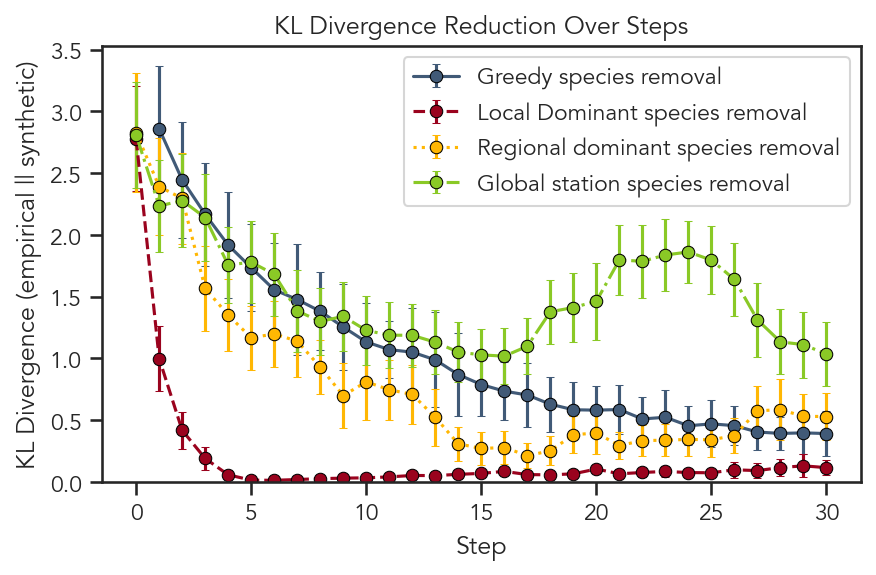

In [164]:
hist = pd.DataFrame(hist)

fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(
    hist['step'],
    hist['KL_mean_after'],
    yerr=hist['KL_std_after'],
    marker='o',
    capsize=2,
    linestyle='-',
    color='#415a77',
    lw=1.5,
    markerfacecolor='#415a77',
    markeredgecolor='black',
    markeredgewidth=0.5,
    label='Greedy species removal'
)

ax.errorbar(
    results_local['n_bloomers'],
    results_local['KL_mean'],
    yerr=results_local['KL_std'],
    marker='o',
    capsize=2,
    linestyle='--',
    color='#9a031e',
    lw=1.5,
    markerfacecolor='#9a031e',
    markeredgecolor='black',
    markeredgewidth=0.5,
    label='Local Dominant species removal'
)

ax.errorbar(
    results_clusters['n_bloomers'],
    results_clusters['KL_mean'],
    yerr=results_clusters['KL_std'],
    marker='o',
    capsize=2,
    linestyle=':',
    color='#ffb703',
    lw=1.5,
    markerfacecolor='#ffb703',
    markeredgecolor='black',
    markeredgewidth=0.5,
    label='Regional dominant species removal'
)   

ax.errorbar(
    results_global['n_bloomers'],
    results_global['KL_mean'],
    yerr=results_global['KL_std'],
    marker='o',
    capsize=2, 
    linestyle='-.',
    color='#8ac926',   
    lw=1.5,
    markerfacecolor='#8ac926',
    markeredgecolor='black',
    markeredgewidth=0.5,
    label='Global station species removal'
)

ax.set_xlabel('Step')
ax.set_ylabel('KL Divergence (empirical || synthetic)')
ax.set_title('KL Divergence Reduction Over Steps')
ax.set_ylim(bottom=0)

figname = "KL_divergence_reduction_comparison.png"
ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, figname), dpi=300)